# Modis Snow Covered Extent with Elevation from 2000-2017

Here we use a cleaned, cloud free daily MODIS snow covered extent product from a 2019 publication in Nature to quantify the change of snow covered extent during anomalously wet and dry spring seasons defined between April and June. Data can be downloaded using `wget https://figshare.com/ndownloader/articles/5902381/versions/4` to the `data/snowdata/modis_sca` directory and unzipped.

Citation:
Tran, Hoang Viet; Nguyen, Phu; Ombadi, Mohammed; Hsu, Kuo-lin; Sorooshian, Soroosh; Xia, Qing (2018). A cloud-free MODIS snow cover dataset for the contiguous United States from 2000 to 2017. figshare. Dataset. https://doi.org/10.6084/m9.figshare.5902381.v4

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import rioxarray as rxr
import geopandas as gpd

Let's get the seasonal anomalies in spring precipitation

In [2]:
seasonal_ppt_ds = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt_14710.nc')
# filter to dates after Fall 1963
seasonal_ppt_ds = seasonal_ppt_ds.sel(month=slice('1963-09-30', '2022-09-30'))
# filter to only spring
spring_ppt_ds = seasonal_ppt_ds.where(seasonal_ppt_ds.month.dt.month.isin([4,5,6]), drop=True)
# calculate the normalized anomaly for spring
spring_ppt_ds_norm = (spring_ppt_ds - spring_ppt_ds.mean(dim='month')) / spring_ppt_ds.std(dim='month')
# filter to times between 2000 and 2017
spring_ppt_ds_norm_2000_2017 = spring_ppt_ds_norm.sel(month=slice('2000-10-01', '2016-09-30'))
# get the years in the lowest quartile for each site
spring_ppt_ds_norm_2000_2017_low_quartile = spring_ppt_ds_norm_2000_2017.where(spring_ppt_ds_norm_2000_2017 < spring_ppt_ds_norm.quantile(0.25, dim='month'), drop=True)
# get the years in the highest quartile for each site
spring_ppt_ds_norm_2000_2017_high_quartile = spring_ppt_ds_norm_2000_2017.where(spring_ppt_ds_norm_2000_2017 > spring_ppt_ds_norm.quantile(0.75, dim='month'), drop=True)

In [3]:
# get the value counts for each year
low_value_counts = spring_ppt_ds_norm_2000_2017_low_quartile.count(dim='station_id')
highest_value_counts = spring_ppt_ds_norm_2000_2017_high_quartile.count(dim='station_id')
# only get years where greater than 50% of the stations are in the lowest quartile
lowest_years = low_value_counts.where(low_value_counts > 13, drop=True).month.dt.year.values
highest_years = highest_value_counts.where(highest_value_counts > 13, drop=True).month.dt.year.values

In [4]:
# add a water year variable to seasonal_ppt_ds
seasonal_ppt_ds['water_year'] = seasonal_ppt_ds.month.dt.year.where(seasonal_ppt_ds.month.dt.month<10, seasonal_ppt_ds.month.dt.year + 1)
# calculate the water year total for each site
water_year_ppt_ds = seasonal_ppt_ds.groupby('water_year').sum(dim='month')
# calculate the normalized anomaly for water year total
water_year_ppt_ds_norm = (water_year_ppt_ds - water_year_ppt_ds.mean(dim='water_year')) / water_year_ppt_ds.std(dim='water_year')
# filter to times between 2000 and 2017
water_year_ppt_ds_norm_2000_2017 = water_year_ppt_ds_norm.sel(water_year=slice(2000, 2016))
# get the years in the lowest quartile for each site
water_year_ppt_ds_norm_2000_2017_low_quartile = water_year_ppt_ds_norm_2000_2017.where(water_year_ppt_ds_norm_2000_2017 < water_year_ppt_ds_norm.quantile(0.25, dim='water_year'), drop=True)
# get the years in the highest quartile for each site
water_year_ppt_ds_norm_2000_2017_high_quartile = water_year_ppt_ds_norm_2000_2017.where(water_year_ppt_ds_norm_2000_2017 > water_year_ppt_ds_norm.quantile(0.75, dim='water_year'), drop=True)
# get the value counts for each year
wy_low_value_counts = water_year_ppt_ds_norm_2000_2017_low_quartile.count(dim='station_id')
wy_highest_value_counts = water_year_ppt_ds_norm_2000_2017_high_quartile.count(dim='station_id')
# only get years where greater than 50% of the stations are in the lowest quartile
wy_lowest_years = wy_low_value_counts.where(wy_low_value_counts > 13, drop=True).water_year.values
wy_highest_years = wy_highest_value_counts.where(wy_highest_value_counts > 13, drop=True).water_year.values

## Get UCRB boundary, Modis SCA, and DEM datasets

In [5]:
ucrb_boundary = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')

In [8]:
if os.path.exists('../data/snowdata/modis_sca/processed/ucrb_modis_sca.nc'):
    sca_elevation_ds = xr.open_dataset('../data/snowdata/modis_sca/processed/ucrb_modis_sca.nc')
    # open _dem
    dem_ds = rxr.open_rasterio('../data/geodata/ucrb_dem_150m.tif')
    # reporject to ds
    dem_ds = dem_ds.rio.reproject_match(sca_elevation_ds)

    # drop nan values and clip to ucrb
    dem_ds = dem_ds.where(dem_ds > 0, drop=True).squeeze()
else:
    ds = xr.open_mfdataset('../data/snowdata/modis_sca/*.nc')
    # add crs as 4326
    ds = ds.rio.write_crs(4326)
    # rename lon to x and lat to y
    ds = ds.rename({'lon':'x', 'lat':'y'})
    # clip to ucrb_boundary
    ds = ds.rio.clip(ucrb_boundary.geometry, ucrb_boundary.crs)
    # open _dem
    dem_ds = rxr.open_rasterio('../data/geodata/ucrb_dem_150m.tif')
    # reporject to ds
    dem_ds = dem_ds.rio.reproject_match(ds)

    # drop nan values and clip to ucrb
    dem_ds = dem_ds.where(dem_ds > 0, drop=True).squeeze()
    print('After filtering out nan values and clipping to ucrb')

    # reporject match ds to dem_ds
    ds = ds.rio.reproject_match(dem_ds)
    # remove grid mapping attribute in Snow_Cover_Extent
    ds['Snow_Cover_Extent'].attrs = {k: ds['Snow_Cover_Extent'].attrs[k] for k in ds['Snow_Cover_Extent'].attrs if k != 'grid_mapping'}

    dem_ds.name = 'elevation'
    # merge the datasets
    sca_elevation_ds = xr.merge([ds, dem_ds], compat='override', join='override')
    # save the dataset
    sca_elevation_ds.to_netcdf('../data/snowdata/modis_sca/processed/ucrb_modis_sca.nc')

## Combine DEM and Snow Cover Extent and group data into 100 meter wide elevation bins.

In [9]:
# groupby elevation bins based on the min and max elevation by 100 m intervals
elevation_bins = np.arange(dem_ds.min().values, dem_ds.max().values, 150)
sca_elevation_ds_binned = sca_elevation_ds.groupby_bins('elevation', elevation_bins).mean()
# filter to times between October 1, 2000 and September 30, 2016
sca_elevation_ds_binned = sca_elevation_ds_binned.sel(time=slice('2000-10-01', '2016-09-30'))
# add water year variable
time = sca_elevation_ds_binned.time.to_pandas()
# for months 10-12 add 1 to the year
time = time.where(time.dt.month < 10, time + pd.DateOffset(years=1))
sca_elevation_ds_binned['time'] = time
# drop band and spatial_ref
sca_elevation_ds_binned = sca_elevation_ds_binned.drop_vars(['band', 'spatial_ref'])
# sort by time
sca_elevation_ds_binned = sca_elevation_ds_binned.sortby('time')

## Filter to High Spring P and Low Spring P years

In [10]:
low_spr_p_sca_elevation_ds_binned = sca_elevation_ds_binned.where(sca_elevation_ds_binned.time.dt.year.isin(lowest_years), drop=True)
high_spr_p_sca_elevation_ds_binned = sca_elevation_ds_binned.where(sca_elevation_ds_binned.time.dt.year.isin(highest_years), drop=True)

## Calculate Monthly and Seasonal Means for the average over the period, the low spring years and the high spring years

In [12]:
#calculate the monthly mean
sca_elevation_ds_binned_monthly = sca_elevation_ds_binned.groupby('time.month').mean()
low_spr_p_elevation_ds_binned_monthly = low_spr_p_sca_elevation_ds_binned.groupby('time.month').mean()
high_spr_p_elevation_ds_binned_monthly = high_spr_p_sca_elevation_ds_binned.groupby('time.month').mean()

# # dates 
# dates = pd.to_datetime(['2017-'+m.astype(str)+'-01' for m in sca_elevation_ds_binned_monthly.month.values])

# # replace month with dates
# sca_elevation_ds_binned_monthly['month'] = dates
# low_spr_p_elevation_ds_binned_monthly['month'] = dates
# high_spr_p_elevation_ds_binned_monthly['month'] = dates
# get the 12, 1,2 average
winter_sca_elevation_ds_binned_monthly = sca_elevation_ds_binned_monthly.where(sca_elevation_ds_binned_monthly.month.isin([12,1,2]), drop=True).mean(dim='month')
low_winter_spr_p_elevation_ds_binned_monthly = low_spr_p_elevation_ds_binned_monthly.where(low_spr_p_elevation_ds_binned_monthly.month.isin([12,1,2]), drop=True).mean(dim='month')
high_winter_spr_p_elevation_ds_binned_monthly = high_spr_p_elevation_ds_binned_monthly.where(high_spr_p_elevation_ds_binned_monthly.month.isin([12,1,2]), drop=True).mean(dim='month')
# get the 3,4,5 average
spring_sca_elevation_ds_binned_monthly = sca_elevation_ds_binned_monthly.where(sca_elevation_ds_binned_monthly.month.isin([3,4,5]), drop=True).mean(dim='month')
low_spring_spr_p_elevation_ds_binned_monthly = low_spr_p_elevation_ds_binned_monthly.where(low_spr_p_elevation_ds_binned_monthly.month.isin([3,4,5]), drop=True).mean(dim='month')
high_spring_spr_p_elevation_ds_binned_monthly = high_spr_p_elevation_ds_binned_monthly.where(high_spr_p_elevation_ds_binned_monthly.month.isin([3,4,5]), drop=True).mean(dim='month')
# get the 6,7,8 average
summer_sca_elevation_ds_binned_monthly = sca_elevation_ds_binned_monthly.where(sca_elevation_ds_binned_monthly.month.isin([6,7,8]), drop=True).mean(dim='month')
low_summer_spr_p_elevation_ds_binned_monthly = low_spr_p_elevation_ds_binned_monthly.where(low_spr_p_elevation_ds_binned_monthly.month.isin([6,7,8]), drop=True).mean(dim='month')
high_summer_spr_p_elevation_ds_binned_monthly = high_spr_p_elevation_ds_binned_monthly.where(high_spr_p_elevation_ds_binned_monthly.month.isin([6,7,8]), drop=True).mean(dim='month')
# get the 9,10,11 average
fall_sca_elevation_ds_binned_monthly = sca_elevation_ds_binned_monthly.where(sca_elevation_ds_binned_monthly.month.isin([9,10,11]), drop=True).mean(dim='month')
low_fall_spr_p_elevation_ds_binned_monthly = low_spr_p_elevation_ds_binned_monthly.where(low_spr_p_elevation_ds_binned_monthly.month.isin([9,10,11]), drop=True).mean(dim='month')
high_fall_spr_p_elevation_ds_binned_monthly = high_spr_p_elevation_ds_binned_monthly.where(high_spr_p_elevation_ds_binned_monthly.month.isin([9,10,11]), drop=True).mean(dim='month')

# combine each into a single seasonal dataset
sca_elevation_ds_binned_seasonal = xr.concat([winter_sca_elevation_ds_binned_monthly, spring_sca_elevation_ds_binned_monthly, summer_sca_elevation_ds_binned_monthly, fall_sca_elevation_ds_binned_monthly], dim='month')
low_spr_p_elevation_ds_binned_seasonal = xr.concat([low_winter_spr_p_elevation_ds_binned_monthly, low_spring_spr_p_elevation_ds_binned_monthly, low_summer_spr_p_elevation_ds_binned_monthly, low_fall_spr_p_elevation_ds_binned_monthly], dim='month')
high_spr_p_elevation_ds_binned_seasonal = xr.concat([high_winter_spr_p_elevation_ds_binned_monthly, high_spring_spr_p_elevation_ds_binned_monthly, high_summer_spr_p_elevation_ds_binned_monthly, high_fall_spr_p_elevation_ds_binned_monthly], dim='month')

# rename the month to season
sca_elevation_ds_binned_seasonal = sca_elevation_ds_binned_seasonal.rename({'month':'season'})
low_spr_p_elevation_ds_binned_seasonal = low_spr_p_elevation_ds_binned_seasonal.rename({'month':'season'})
high_spr_p_elevation_ds_binned_seasonal = high_spr_p_elevation_ds_binned_seasonal.rename({'month':'season'})

## Plot Monthly and Seasonal Means for a defined period of time

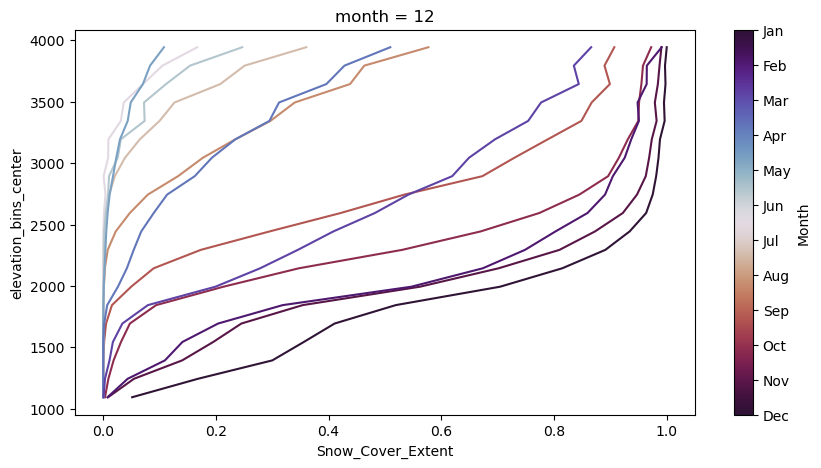

In [14]:
# plot each month and color with cyclic colormap
fig, ax = plt.subplots(figsize=(10, 5))
for i, month in enumerate(sca_elevation_ds_binned_monthly.month):
    cax = sca_elevation_ds_binned_monthly.sel(month=month).Snow_Cover_Extent.plot(y='elevation_bins',ax=ax, label=month.values, color=plt.cm.twilight_shifted_r(i/12))

# add custom colorbar to the plot with labels as month names
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.twilight_shifted_r), 
                    ax=ax, 
                    orientation='vertical', 
                    label='Month')
cbar.set_ticks(np.linspace(1, 0, 12))
cbar.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


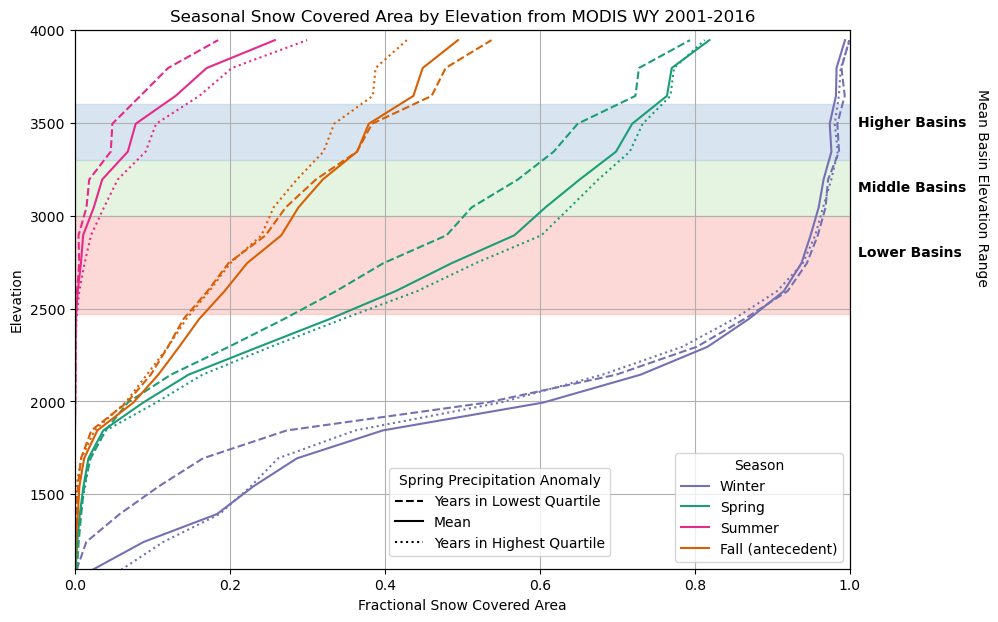

In [16]:
# plot each month and color with cyclic colormap
fig, ax = plt.subplots(figsize=(10, 7))
# four distinct colors for the four seasons
s = ['Winter', 'Spring', 'Summer', 'Fall (antecedent)']
colors = ['#7570b3','#1b9e77','#e7298a','#d95f02',]
for i, season in enumerate(low_spr_p_elevation_ds_binned_seasonal.season):
    low_spr_p_elevation_ds_binned_seasonal.sel(season=season).Snow_Cover_Extent.plot(y='elevation_bins',ax=ax, color=colors[i], ls='--')
    sca_elevation_ds_binned_seasonal.sel(season=season).Snow_Cover_Extent.plot(y='elevation_bins',ax=ax, color=colors[i], ls='-',label=s[i])
    high_spr_p_elevation_ds_binned_seasonal.sel(season=season).Snow_Cover_Extent.plot(y='elevation_bins',ax=ax, color=colors[i], ls=':')
# add a horizontal band between 2470 and 2900
ax.axhspan(2470, 3000, color='#fbb4ae', alpha=0.5,)
# add a text annotation for the band just above the bottom of the band at 2470 
ax.text(1.01, 2800,'Lower Basins ', ha='left', va='center', color='black', fontsize=10, weight='bold')
# add a horizontal band between 2900 and 3200
ax.axhspan(3000, 3300, color='#ccebc5', alpha=0.5,)
# add a text annotation for the band just above the bottom of the band at 2470 
ax.text(1.01, 3150,'Middle Basins', ha='left', va='center', color='black', fontsize=10, weight='bold')
# add a horizontal band between 3200 and 3600
ax.axhspan(3300, 3600, color='#b3cde3', alpha=0.5,)
# add a text annotation for the band just above the bottom of the band at 2470 
ax.text(1.01, 3500,'Higher Basins', ha='left', va='center', color='black', fontsize=10, weight='bold')
# add vertical text saying Mean Elevation Range
ax.text(1.17, 3150,'Mean Basin Elevation Range', ha='center', va='center',rotation=270, color='black', fontsize=10, )
# ghost twin axis for the second legend
styles = ['--','-',':']
labels = ['Years in Lowest Quartile', 'Mean', 'Years in Highest Quartile']
ax2 = ax.twinx()
for ss, sty in enumerate(styles):
    ax2.plot([], [], ls=styles[ss],
             label=labels[ss], c='black')
ax2.get_yaxis().set_visible(False)

ax.legend(title = 'Season')
ax2.legend(title='Spring Precipitation Anomaly',
bbox_to_anchor=(0.7,0.2),)

ax.set_ylabel('Elevation')
ax.set_xlabel('Fractional Snow Covered Area')
ax.set_title('Seasonal Snow Covered Area by Elevation from MODIS WY 2001-2016')
ax.set_xlim(0, 1)
ax.set_ylim(1100,4000)
ax.grid()
